## Object Tracking

For a project, we are going to be working on object detection/object tracking. To accomplish this task we have identified a primary method than can accomplish this that come from the paper Fully-Convolutional Siamese Networks for Object Tracking. In researching the problem of object tracking I found another interesting paper--Online Multi-Object Tracking with Dual Matching Attention Networks that can offer an alternative solution. After the summary of this paper I have included a project outline.

### Paper: Online Multi-Object Tracking with Dual Matching Attention Networks

Source: https://openaccess.thecvf.com/content_ECCV_2018/papers/Ji_Zhu_Online_Multi-Object_Tracking_ECCV_2018_paper.pdf

As with other recent models I have examined this paper uses attention mechanisms but for the purpose of multi-object tracking. The researchers will propose a framework that can handle noisy detections and they will propose a cost-sensitive tracking loss which help distinguash hard examples. The framework they propose is called Dual Matching Attention Networks (DMAN) that utilize an attention mechanism in the spatial and temporal dimensions which was an idea mentioned in my last report on Non-Local Networks in their non-local block.

The task of Multi-Object Tracking (MOT) is used for finding target locations and tracking their trajectories. We start by introducing two kinda of MOT, offline and online. Offline utilizes all the frames in a video to generate trajectories. Online, on the other hand do not utilize any future frames as the name implies. Online MOT is useful in that it is more applicable to real-time vision tasks. MOT typically use tracking-by-detection and link the detections from multiple frames using association algorithms, which are very sensitive to the quality of detection results. Recently, methods for MOT utilize techniques from single object tracking detection to initially find an object at which point the online method updates the model to find and track the object in following frames. In most frames, the authors use a single object tracker to track each target and modify their approach when the object is occluded or changes in appearance.

Using a single object tracker for MOT has issues with interactions between targets as well as noise from intra-class distractors. Additionally, single object tracking methods are hindered from class imbalance as only a few locations near the target center result in positive samples and all other sampled positions are negative. It is important to consider that labeling positions as not containing the object is a relatively easy task that can cause discriminative abilities of the model to diminish. Thus, it is important to really focus on hard examples during online updates. I suspect that the proposed loss will be a modification of an existing loss function where hard examples are given vastly more importance than easy examples, but we will see what is implemented later in the paper.

One common area of MOT is in pedestrian tracking as pose variation, similarities in appearance, and object occulusion are challenging tasks. Detection regions in this task tend to be rather noisy and it is quite easy for the object tracking model to make poor predictions. To remedy this, two points are presented:
- The proposed model should focus on local regions between observations to improve misaligned and missing parts in detections
- The model should assign different weights to different observations in the trajectory

We close out the introduction with a high-level overview of the contributions of the paper. To handle noisy detections for MOT they propose a spatial attention network where the network generates two spatial attention maps to compare frames. A temporal attention network is used to attend to the different observations in the trajectory. They apply a single object tracker in MOT and a new cost-sensitive tracking loss that focuses on sparse, hard samples. Finally, they perform experiments and demonstrate the performance on their novel architecture.

Next, we will take a look at the related work section. MOT methods vary, but many use detections from both past and future frames for training. Online MOT methods require a robust appearance model and recently (in respect to the publicaiton) saw the introduction of several online deep learning models for this task. The Siamese architectures have been used for such tasks before, as well as an LSTM to account for appearance modeling and calculating similarity scores. For the attention model, they primarily borrow from image captioning and visual question answering. Data imbalance is a common problem in computer vision tasks, especially in object-detection oriented tasks. One soltuion found in previous research is to mine hard negative examples during training. Assigning more importance to these examples can help with generalization and ultimately prevent drifting. Lastly, the state-of-the-art STAM method for object tracking utilizes a spatial-temporal attention mechanism into the MOT algorithm but is different in 3 key ways:
1. the spatial attention in STAM corresponds to the visibility map
2. proposed model's spatial attention map can be learned without pixel-level annotation
3. temporal attention in the proposed model can attend less to noisy samples

Moving on to the proposed online MOT algorithm. As mentioned previously, multiple single object trackers are used to track multiple objects above a specified tracking score. Tracking is halted if a target is lost and the similarity between frames is computed. If the target is detected through this association process, the tracking process is re-initiated. For the baseline tracker they use Efficient Convolution Operators (ECO). The ECO paper itself it somewhat a dense read, but luckily the authors provide a succint summary on how it realtes to their approach. They start with a vector $x$ of feature maps which is comprised of $D$ feature channels and has a resolution of $N_d$. The channels are then interpolated to in the domain $[0,T)$ and learns a $T$-periodic multi-channel convolutional filter represented as the vector $f$. The loss function being optimized here is: 

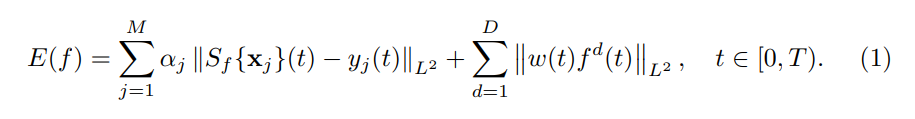

$\alpha_j$ is the weight given to a sample $x_j$ and the convolution $S_f$ maps $x_j$ to a score function $S_f\{x_j\}(t)$ which outputs the confidence of the target at the location $t$ in the interval $[0,T)$. $y_j(t)$ here is the desired output. They include the regularization term $w(t)$ to help control boundary effects. The authors provide a matrix (vectorized) version of this formula in which the objective function is shown as a least-squares problem. With the understanding of the objective function for the baseline tracker, we turn our attention to the cost-sensitive tracking loss. The ECO tracker uses circular shifted versions of an image patch to train the filter and produce a confidence map. Consider the following confidence map below:

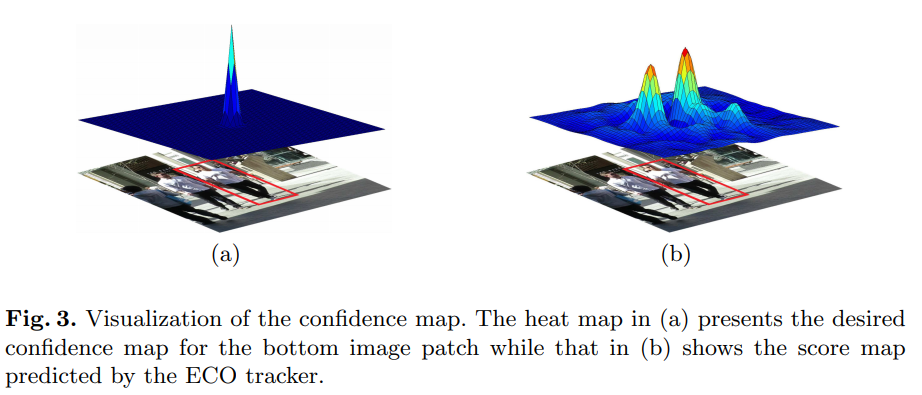

The red bounding box represents our target and we can visualize the confidence map with the map located above the image. We see that values are primarily very close to the center of the target while all other values are essentially 0. In (b), we see that the ECO tracker produces high confidence for the individual next to our target. The second "bump" in the confidence map is indicative of a distractor and should be regarded as a difficult sample, i.e., the model can likely predict the person next to our target as the desired target. The aim is to penalize these examples heavily which is an issue when using the ECO objective function as shifted samples in the same search area are weighted equally. This is problematic as most negative samples come from the background which can degrade the discriminative power of the model on hard samples. The authors introduce a new formulation of the ECO objective function:

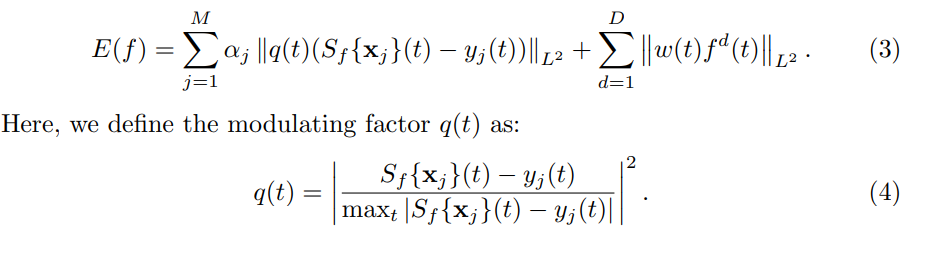

Here $q(t)$ is used to change the weights of circular shifted samples in respect to their loss. A benefit of using this methodology is that $q(t)$ can be pre-computed before each training step as they use the filter learned in the last model update step to compute $q(t)$.


Next, we tackle data association and the dual matching attention network. When the tracking object is lost, the data association algorithm is used to determine whether to say the target is lost or transfer it to a tracked state. One interesting point the authors note is that if you were to rely on tracking score only, a false alarm detection on the background could likely be tracked with high confidence. To filter out such false alarms, they use the overlap between bounding boxes from the tracker and detector. They consider the maximum overlap ratio between the tracked target and the detections in $l$ frames and take the mean of an indicator variable if the observed ratio is above or below 0.5. Formally, they define this as

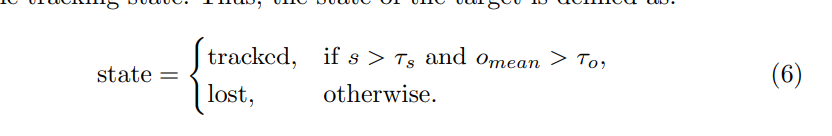

Before they compute the similarity they use motion cues for candidate detections. This means that the scale of the bounding box is kept the same and use a linear motion model to predict the location in a future frame. This is accomplished by taking the coordinates at the previous frame, subtracting the coordinates $K$ frames before that, and taking the average over $K$ frames to obtain a velocity. Then the coordinates at frame $k-1$ (previous frame) are added with the velocity to get the current coordinates of the target. Detections surrounding the predicted location are also considered and measure the appearance affinity. Using a threshold for the affinity value, a decision is made to link the lost target to the detection. This information presented in the last few paragraphs is somewhat abstract, and I think it is more effective to consider the figure and caption they have provided on their model architecture as a summary.

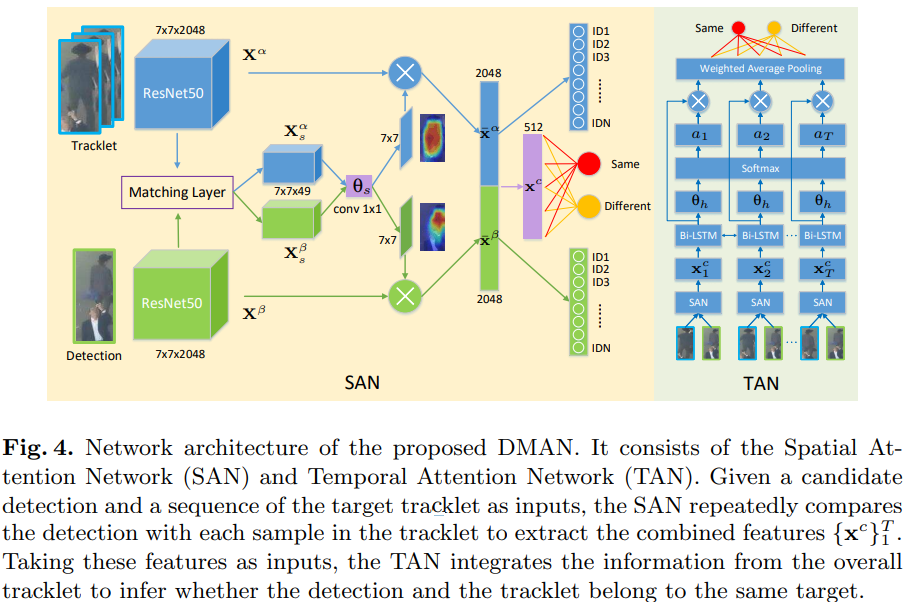

Note that the figure contains two pieces: the spatial attention network and the temporal attention network. The spatial attention network uses a Siamese architecture with a truncated ResNet-50 network. L-2 normalization is applied along the channel dimension for output features. The spatial attention map is applied at the last convolutional layer to capture more global information and high level information. The spatial attention network should attend more to common local patterns of two feature maps. However, the authors note this may not be the case due to pose change and inacurate bounding boxes and choose to generate the attention map for each input separately. They utilize identification loss and verification loss to train the network and simultaneously identify each image in the input pair as well as produce a similarity score between the two pairs. For identification, they use cross entropy loss on the masked features and input the concatenated feature maps into a fully connected layer. Then a binary classifier is used to obtain a prediction.

The temporal attention network is used for comparing detection with a sequence of observations. Assigning equal weights to observations in a tracklet degrades model performance and is remedied by attending to different samples in the tracklet. Rather than focus on similarity between the detection and each sample in the tracklet it would be better to consider the consistency between all samples through attention. To accomplish this, the authors use a Bi-direction LSTM model to predict the attention value. They then pool the hidden representations from the Bi-LSTM using the attention weights which is fed to the binary classifier which will calculate the similarity score between the detection and tracklet. Using the pairwise similarity scores of detections and tracklets, they assignments between candidate detections and lost targets.

To train their model, the MOT16 training set is used. They note that the dataset has consecutive samples with redundancies which can lead to overfitting in the model. This leads them to first train the spatial attention network on randomly generated image pairs, fix the weights of the network, and use the features as inputs to train the temporal attention network. Augmentation is used in which they randomly crop and rescale the input images. Additionally, noisy samples are added to improve robustness. To determine when to terminate trajectory prediction they choose a threshold over a specified number of frames or if the target leaves the field of view.

As for evaluation metrics, they used those in the MOT challenge. I will not list them here as there are a large number of metrics that we will see later in the tables displaying the results. As mentioned before, they utilize the features found in ECO-HC for single object tracking. Pre-trained ResNet-50 convolution blocks are used for data association. Tracklet length is set to 8 and the maximum number of samples in the tracjectory is set to 100. The interval used in the velocity calculation is set to 30% of the frame rate.

We start by looking at the visualization of the attention networks for model evaluation. 

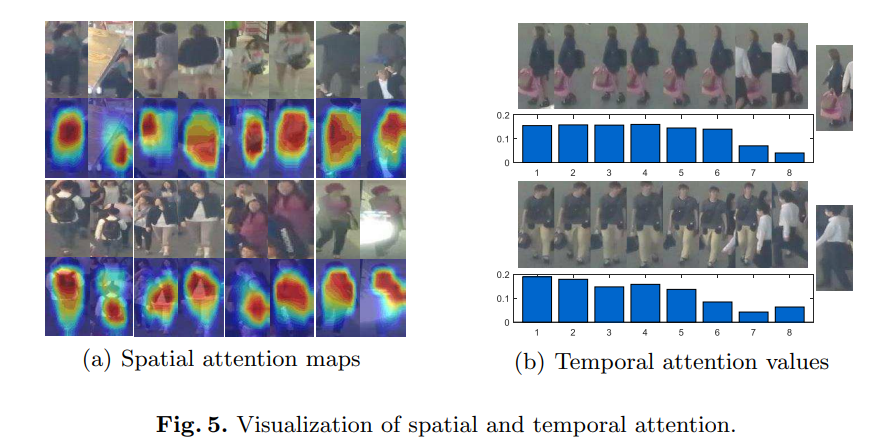

We can see that even after scale changes or occlusions, the network is able to properly attend to detections. We also see that distractors and background are not focused on as much as our target region. For example, the lower left image has a scale change and the lower right image has noise/occlusion but we can clearly see that the attention map is still capturing our target accurately. Part (b) of the figure above gives the attention scores from the temporal network. The sequence of images are the tracklet that correspond to the candidate detection which is seen to the right. The blue bars represent the attention value for each image in the tracklet. We see that when we have a clear view of the candidate, the attention values are quite high. When an occlusion is introduced, e.g. another person, we see the attention values drop significantly.

To demonstrate the effectiveness of their architecture, performed ablation studies:
1. They disable the dual matching attention networks and only rely on the cost-sensitive tracker to link detections
2. They disable the spatial attention module and use a standard Siamese CNN network for identity verificaiton
3. Temporal attention pooling replaces with max pooling
4. Use of baseline tracker without new cost-sensitive tracking loss

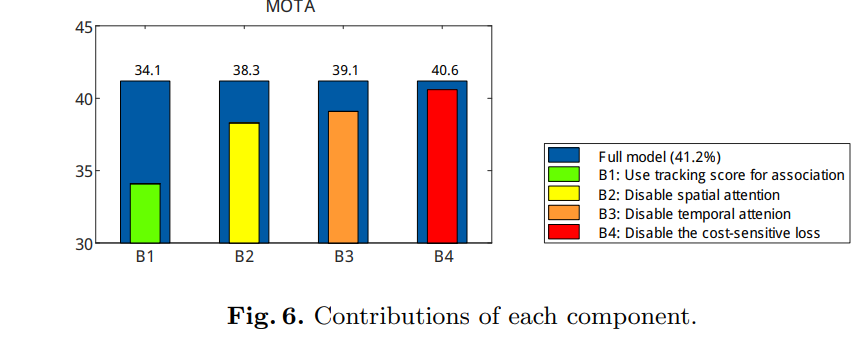

Here we see that each aspect of the network plays an important role in the overall performance when benchmarking on the MOT16 training dataset. The way to interpret this plot is to consider the full MOTA score of 41.2% and the numbers above the blue bars being the performance with modification. We see that using tracking score for association has the biggest impact and performance is decreased drastically. The other changes show a performance decrease of a less drastic scale, and the cost-sensitive tracking loss provides only minor improvement.

For overall evaluation, the authors use MOT16 and MOT17 as their benchmark datasets. The results are then compared against state-of-the-art models in the following tables:

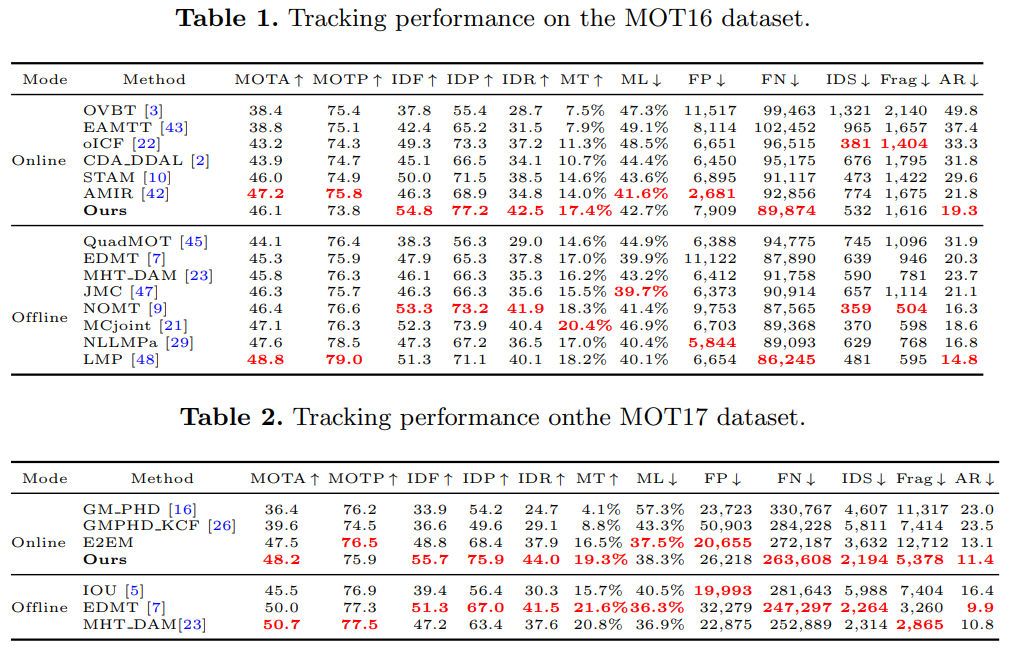

After viewing the table, it is refreshing to see an architecture isn't the best in every metric and just blows every other model away but rather offered as an alternative and succeeds in some aspects but not others. The point is made though that their model is on par with state-of-the-art models and performs better on some metrics than others. Since this is an online method, let's focus on the top half of table 1. We see the metrics where DMAN shines is with IDF, IDP, IDR, MT, FN, and AR. A refresher on these metrics:

- IDF: ratio of correct detections over the average number of ground-truth and computed detections
- IDP: the fraction of detections that are correctly identified
- IDR: the fraction of ground-truth detections that are correctly identified
- MT: the ratio of mostly tracked targets
- FN: false negatives
- AR: average ranking score suggested by MOT benchmarks

(the complete list of metrics can be found under section 4 of the paper)

Table 2 which measures the tracking performance on the MOT17 dataset. Again, we see state of the art performance across nearly all metrics and slightly better performance compared to the MOT16 dataset. One thing I wish the authors had expanded upon was at what frame rate their method is able to handle and overall metrics regarding the speed of their approach. In conclusion, we saw that this novel method of multi-object tracking allows for state-of-the art performance in an online setting through the use of a cost-sensitive tracking object function, a spatial attention network, and a temporal attention network.

# Object Detection EDA

For my part of the group project I plan to implement object detection model(s). I think the first part for understanding a project from end-to-end should be to investigate the data that will be used. Here I will be exploring some datasets that can potentially be used. Here I want to look at arguably the most famous object detection, COCO, as well as potentially one or two more. It be ideal to find a much smaller object detection dataset that is much more friendly to a home GPU that can be used to demonstrate viability in a large scale project.

### COCO Dataset

### Dataset Download

Here I'm going to be focusing my EDA on the training set which can be downloaded using the following link:
http://images.cocodataset.org/zips/train2017.zip

The COCO dataset also has a Python API which I think would be useful to get familiar with. I am using the demo here as a guide: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

######################################################################################################################################

The guide uses the validation set, however, I downloaded the training set to perform EDA.

In [3]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import PIL
import pickle



#specifying the directories
dataDir='E:\Datasets\COCO'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [4]:
coco = COCO(annFile)

loading annotations into memory...
Done (t=14.68s)
creating index...
index created!


In [5]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))
print("Number of Object Categories:", len(cats))


nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))
print("Number of Object supercategories:", len(nms))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

Number of Object Categories: 80
COCO supercategories: 
animal food outdoor furniture indoor person accessory electronic appliance kitchen sports vehicle
Number of Object supercategories: 12


Here we load in all of the category IDs, get the image IDs corresponding to these cattegories and randomly choose one to show.

In [6]:
# get all images containing given categories, select one at random
#seed set for reproducability

np.random.seed(5)
catIds = coco.getCatIds(catNms=['person','airplane','glove']);
imgIds = coco.getImgIds(catIds=catIds );
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

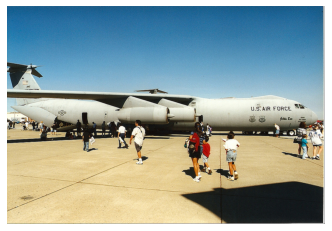

In [7]:
# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

Next, we are going to display the image with the annotation, and draw the bounding boxes for the objects.

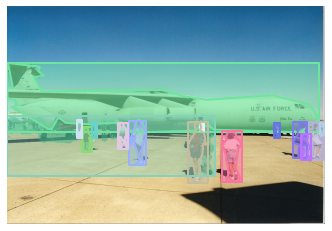

In [8]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)

In [9]:
categories = []

for i in range(len(anns)):
    categories.append(anns[i]['category_id'])

print(categories)

[5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Here we see that this image only has two categories--an airplane and several people.

To understand the full functionality of the API I found that directly looking at the Python code was actually better than using the guide (https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py). The guide also has some additional code to display some keypoints for what looks like pose estimation as well as a caption that can be used for image captioning projects. This is outside of the scope of what I intend to use this for, so I am going to skip this.

Now that we have taken a look at a sample image I'm going to do a more comprehensive EDA using the validation set because the training set is quite large

In [10]:
coco_data = torchvision.datasets.CocoDetection(r'E:\Datasets\COCO\val2017', annFile=r"E:\Datasets\COCO\annotations\instances_train2017.json", transform = transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(coco_data,
                                          batch_size=16,
                                          shuffle=True,
                                          num_workers=4)

loading annotations into memory...
Done (t=14.33s)
creating index...
index created!


In [11]:
import glob
import numpy as np
from PIL import Image
import json
from dask import bag, diagnostics 
import cv2
import pandas as pd
import hvplot.pandas
import seaborn as sns
import matplotlib.pyplot as plt

filelist = glob.glob('E:/Datasets/COCO/val2017/*.jpg')
x = np.array([np.array(Image.open(fname)) for fname in filelist])

C:\Users\JT\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [12]:
#code taken from https://www.kaggle.com/jpmiller/basic-eda-with-images
def get_dims(file):
    img = cv2.imread(file)
    h,w = img.shape[:2]
    return h,w

# parallelize
dimsbag = bag.from_sequence(filelist).map(get_dims)
with diagnostics.ProgressBar():
    dims = dimsbag.compute()
    
dim_df = pd.DataFrame(dims, columns=['height', 'width'])
sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
sizes.hvplot.scatter(x='height', y='width', size='count', xlim=(0,1200), ylim=(0,1200), grid=True, xticks=2, 
        yticks=2, height=500, width=600).options(scaling_factor=0.1, line_alpha=1, fill_alpha=0)

[########################################] | 100% Completed |  7.9s


:Scatter   [height]   (width,count)

This plot shows us the distribution of the image height and width of our dataset. Bigger circles denote more observations at that set of height and width. We see that we have a pretty diverse set of image sizes, with most of them falling into two categories:
- Having a height or width of 640
- Having a height or width of 500

However, we do see there are a handful of images that are of varying scales.

In [13]:
#open annotations file
with open(r"E:\Datasets\COCO\annotations\instances_val2017.json", 'r') as f:
    annotations = json.load(f)

#extract list of classes and aggregate on count basis
classes = [[[annotations['annotations'][i]['category_id'],1] for i in range(len(annotations['images']))]]
classes = np.array(classes).reshape(-1,2)
classes = pd.DataFrame(classes)
classes_count = classes.groupby(0).count()

In [14]:
#list to store mappings of class id : class name
class_mapping = []

for i in range(len(annotations['categories'])):
    class_mapping.append((annotations['categories'][i]['id'], annotations['categories'][i]['name']))
 
#set index to class id
class_mapping = pd.DataFrame(class_mapping)    
class_mapping.set_index(0, inplace=True)

#map id -> name for plotting by using pandas merge
classes_df = classes_count.merge(class_mapping, left_index=True, right_index=True).sort_values('1_x', ascending=False)
classes_df.columns = ['counts', 'class_names']
classes_df.set_index('class_names', inplace=True)

Text(0.5, 1.0, 'Distribution of Object Classes')

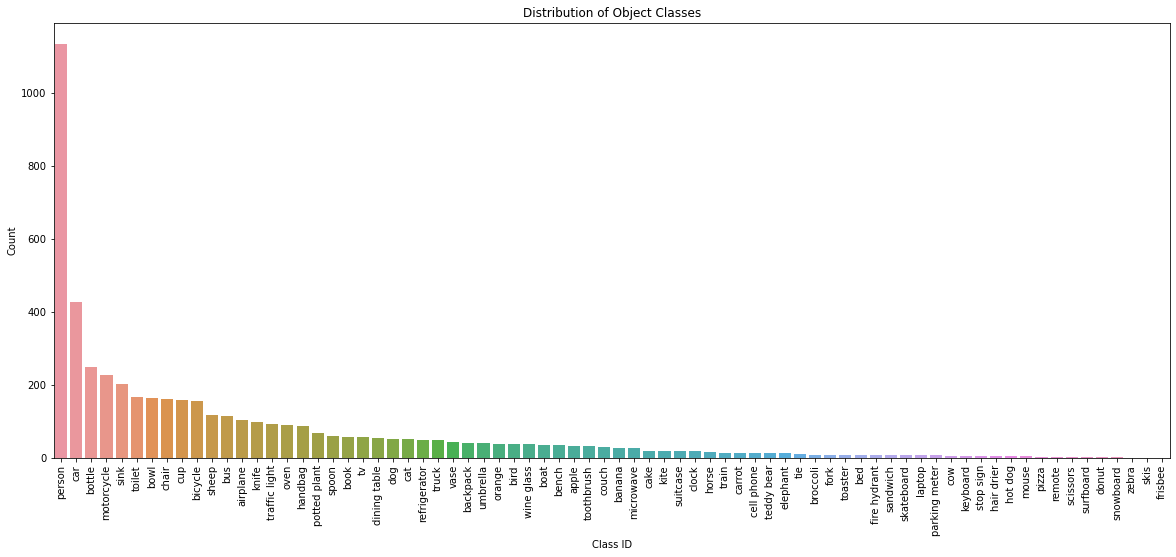

In [15]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x=classes_df.index, y='counts', data=classes_df)
plt.ylabel('Count')
plt.xticks(rotation='90')
plt.xlabel('Class ID')
plt.title('Distribution of Object Classes')

## Feature Pyramid Network

In several papers I have seen on object detection, a feature pyramid network is a common architecture used. Pytorch has a built in FPN, however, the documentation is a little lacking. Upon reviewing the source code, it was slightly confusing and I would like to develop a better understanding by coding it myself. The FPN in a previous paper I have read (Fully Convolutional One-Stage Object Detection) is visualized below for reference:

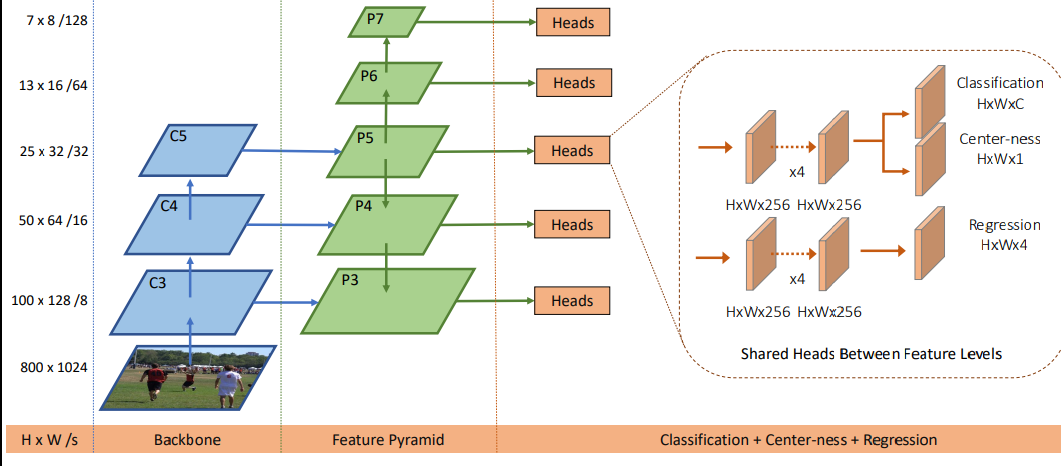

In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import PIL
import pickle
from torchvision.ops import FeaturePyramidNetwork

###################################################################################
#################  Example provided by Torchvision  ###############################
###################################################################################
m = torchvision.ops.FeaturePyramidNetwork([10, 20, 30], 5)
# get some dummy data
x = dict()
x['feat0'] = torch.rand(1, 10, 64, 64)
x['feat2'] = torch.rand(1, 20, 16, 16)
x['feat3'] = torch.rand(1, 30, 8, 8)
# compute the FPN on top of x
output = m(x)
print([(k, v.shape) for k, v in output.items()])

[('feat0', torch.Size([1, 5, 64, 64])), ('feat2', torch.Size([1, 5, 16, 16])), ('feat3', torch.Size([1, 5, 8, 8]))]


Directly from the paper that introduces FPNs is this image:

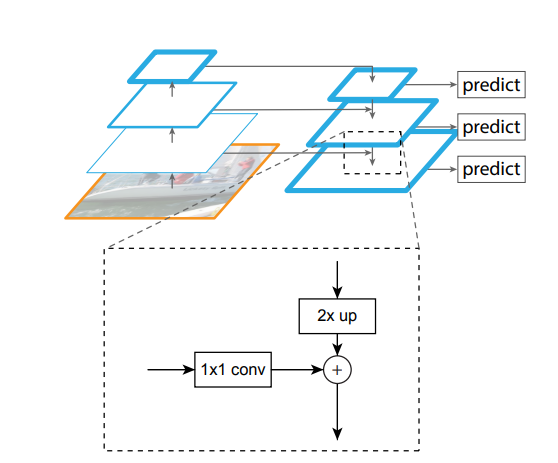

I think this simply summarizes what the arrows in the previous image show and is a decent guide on how each layer is handeled. In the scope of the FCOS paper, the predict boxes would be replaced by FCOS prediction heads.

In [26]:
from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch import nn, Tensor

from torch.jit.annotations import Tuple, List, Dict, Optional



class FPN(nn.Module):
    def __init__(self, out_channels_list, fpn_channels):
        super(FPN, self).__init__()
        
        '''
        out_channels: list of output channels for each feature map
        '''
        self.fpn_channels = fpn_channels
        self.channel_list = out_channels_list
        
        self.conv_P3 = nn.Conv2d(self.channel_list[0], self.fpn_channels, kernel_size = 1, bias=False)
        self.conv_P4 = nn.Conv2d(self.channel_list[1], self.fpn_channels, kernel_size = 1, bias=False)
        self.conv_P5 = nn.Conv2d(self.channel_list[2], self.fpn_channels, kernel_size = 1, bias=False)
       
    
        self.conv_P6 = nn.Conv2d(self.fpn_channels, self.fpn_channels, kernel_size = 3, padding=1, stride=2)
        self.conv_P7 =  nn.Conv2d(self.fpn_channels, self.fpn_channels, kernel_size = 3, padding=1, stride=2)   

        self.alias_reduce3 = nn.Conv2d(self.fpn_channels, self.fpn_channels, kernel_size=3, stride=1, padding=1)
        self.alias_reduce4 = nn.Conv2d(self.fpn_channels, self.fpn_channels, kernel_size=3, stride=1, padding=1)
      
        self.initialize_weights()
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        #x is a list of tensors that contain the feature maps
        
        C3, C4, C5 = x[0], x[1], x[2]
        
        #lateral convolutions
        P3 = self.conv_P3(C3)
        P4 = self.conv_P4(C4)
        P5 = self.conv_P5(C5)
        P6 = self.conv_P6(P5)
        P7 = self.conv_P7(P6)
        
        #upsample is depreciated--use interpolate
        upsample_P5 = F.interpolate(P5, scale_factor=2, mode='bilinear')
        P4 = P4 + upsample_P5

        upsample_P4 = F.interpolate(P4, scale_factor=2, mode='bilinear')
        P3 = P3 + upsample_P4
        
        #final convolutions are used to reduce the aliasing effect
        P4 = self.alias_reduce4(P4)
        P3 = self.alias_reduce3(P3)
        
        return P3, P4, P5, P6, P7
        

Time for a simple test to see if it is working. I'm going to take the image I visualized earlier on (the airplane and people) and convert it to a tensor.

In [27]:
tensor_test = torch.Tensor(I).reshape([1,438,640,3])
tensor_test = tensor_test.permute(0,3,1,2)
tensor_test = F.pad(tensor_test, (0,0,25,0), "constant", 0)

tensor_test.shape

torch.Size([1, 3, 463, 640])

Here I am going to apply 3 convolutions and the FPN class and we will check the shapes of the outputs to verify it is working as expected.

In [28]:
conv1 = nn.Conv2d(3, 24, stride=2, kernel_size=3, padding=1)
conv2 = nn.Conv2d(24, 48, stride=2, kernel_size=3, padding=1)
conv3 = nn.Conv2d(48, 96, stride=2, kernel_size=3, padding=1)
fpn = FPN([24, 48, 96], 256)


C1 = conv1(tensor_test)
C2 = conv2(C1)
C3 = conv3(C2)
fpn_layers = fpn([C1, C2, C3])
names_list = ["P3", "P4", "P5", "P6", "P7"]


for i in range(len(fpn_layers)):
    print(names_list[i], fpn_layers[i].shape)

C:\Users\JT\Anaconda3\envs\deeplearning\lib\site-packages\torch\nn\functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


P3 torch.Size([1, 256, 232, 320])
P4 torch.Size([1, 256, 116, 160])
P5 torch.Size([1, 256, 58, 80])
P6 torch.Size([1, 256, 29, 40])
P7 torch.Size([1, 256, 15, 20])


Great! We get our 1 image with 256 channels and at varying resolutions. One thing to note is that while looking at the resolutions we see that there are odd numbers which leads to some ambiguity when up/down sampling. One solution to this would be to zero pad the image such that every pyramid feature map is divisible by 2 except the last map. Another solution is to resize the images as suggested in the FPN paper such that the          . These would be implemented in the data loading pipeline prior to feeding them into the model. Otherwise, we can see that the FPN is working as expected!

This basic feature pyramid network can be incorporated into other model architectures for region proposal or prediction. For larger FPNs, it would be wise to have a more automatic process to generate the convolutions and pyramid feature maps, but from what I have seen the FPN has not been large.